# Simple RAG LLM Flow
A  implementation of RAG search followed by LLM summarization

## Imports and Setup

In [2]:
from typing import Optional, List, Dict, Any, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
import json
import psycopg2
import ollama
import pprint

/Users/poorvikjaintm/learn_llm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## State Definition

In [3]:
class State(MessagesState):
    """Simple state class for RAG to LLM flow with proper message handling."""
    messages: Annotated[List[BaseMessage], add_messages]
    query: Optional[str] = None
    next_node: Optional[str] = None
    search_results: Optional[Dict[str, Any]] = None

## Node Handlers

In [4]:

DB_CONN = "dbname=ragdb user=postgres password=postgres host=localhost"
EMBED_MODEL = "embeddinggemma"
LLM_MODEL = "phi3:mini"
TOP_K = 1

def embed_text(text: str):
    """Get vector embedding from Ollama."""
    response = ollama.embeddings(model=EMBED_MODEL, prompt=text)
    return response["embedding"]

def search_documents(query: str) -> List[Dict[str, Any]]:
    """Search for relevant documents."""
    q_emb = embed_text(query)
    conn = psycopg2.connect(DB_CONN)
    cur = conn.cursor()
    
    cur.execute("""
        SELECT filename, content, job_information
        FROM json_docs
        ORDER BY embedding <#> %s::vector
        LIMIT %s;
    """, (q_emb, TOP_K))
    
    results = cur.fetchall()
    cur.close()
    conn.close()
    
    return [{
        "filename": r[0],
        "content": r[1],
        "job_information": json.loads(r[2]) if isinstance(r[2], str) else r[2]
    } for r in results]


def rag_handler(state: Dict[str, Any]) -> Dict[str, Any]:
    """Handle document retrieval."""
    try:
        results = search_documents(state["query"])
        if results:
            state["search_results"] = results[0]
            state["next_node"] = "llm"
        else:
            state["messages"].append(AIMessage(content="No matching documents found."))
            state["next_node"] = "end"
    except Exception as e:
        state["messages"].append(AIMessage(content=f"Search error: {str(e)}"))
        state["next_node"] = "end"
    return state

def llm_handler(state: Dict[str, Any]) -> Dict[str, Any]:
    """Generate summary using LLM."""
    if not state.get("search_results"):
        state["messages"].append(AIMessage(content="No search results to summarize."))
        state["next_node"] = "end"
        return state
    
    job_info = state["search_results"]["job_information"].get("job_information", {})
    
    prompt = f"""Job Title: {job_info.get('title')}
Company: {job_info.get('client')}
Location: {job_info.get('location')}

List only the key information from this job posting without adding explanations."""
    
    try:
        response = ollama.chat(model=LLM_MODEL, messages=[{
            "role": "user",
            "content": prompt
        }])
        summary = response["message"]["content"]
        state["messages"].append(AIMessage(content=summary))
    except Exception as e:
        state["messages"].append(AIMessage(content=f"Error generating summary: {str(e)}"))
    
    state["next_node"] = "end"
    return state

In [ ]:
# Match explanation functionality

def search_documents_with_explanation(query: str) -> List[Dict[str, Any]]:
    """Search for relevant documents with match explanation."""
    q_emb = embed_text(query)
    conn = psycopg2.connect(DB_CONN)
    cur = conn.cursor()
    
    cur.execute("""
        SELECT filename, content, job_information, embedding <#> %s::vector as distance
        FROM json_docs
        ORDER BY embedding <#> %s::vector
        LIMIT %s;
    """, (q_emb, q_emb, TOP_K))
    
    query_response = cur.fetchall()
    cur.close()
    conn.close()
    
    results = [{
        "filename": r[0],
        "content": r[1],
        "job_information": json.loads(r[2]) if isinstance(r[2], str) else r[2],
        "distance": r[3]
    } for r in query_response]
    return results

def rag_handler_with_explanation(state: Dict[str, Any]) -> Dict[str, Any]:
    """Handle document retrieval with match explanation."""
    try:
        results = search_documents_with_explanation(state["query"])
        if results:
            state["search_results"] = results[0]
            # Add match explanation
            job_info = results[0]["job_information"].get("job_information", {})
            match_info = f"Match found: {results[0]['filename']} (distance: {results[0]['distance']:.3f})\n'"
            state["messages"].append(AIMessage(content=match_info))
            state["next_node"] = "llm"
        else:
            state["messages"].append(AIMessage(content="No matching documents found."))
            state["next_node"] = "end"
    except Exception as e:
        state["messages"].append(AIMessage(content=f"Search error: {str(e)}"))
        state["next_node"] = "end"
    return state
def intend_handler(state: Dict[str, Any]) -> Dict[str, Any]:
    """Determine next node based on state[query]."""
    prompt2 = f"""Based on this user query: "{state['query']}"
    
Respond with only one word: either "rag" or "end"
- If the query is about jobs, job search, companies, or work-related topics, respond: rag
- If the query is a greeting, casual conversation, or unrelated to jobs, respond: end

Query: {state['query']}
Response:"""
    prompt = f"""Based on this user query: "{state['query']}"
If the user is searching for a job, requesting job details, company information, or discussing anything related to job hunting, return 'rag'.
If the user is greeting (e.g., "hi", "hello", "hey") or saying anything casual or unrelated to jobs, return 'end'.
Respond only with the next node name.

Example:
User: "Can you show me openings at Google?"
Output: rag

User: "Hi there!"
Output: end

User: "I want to find a software developer job."
Output: rag

User: "Good morning!"
Output: end
"""
    
    try:
        response = ollama.chat(model=LLM_MODEL, messages=[{
            "role": "user",
            "content": prompt
        }])
        next_node = response["message"]["content"].strip().lower()
        print("Determined next_node:", next_node)
        
        if next_node == "end":
            state["messages"].append(AIMessage(content="Hello! I can help you search for job information. What would you like to know?"))
            state["next_node"] = "end"
        else:
            state["next_node"] = "rag"
            
    except Exception as e:
        print(f"Error in intent detection: {e}")
        state["next_node"] = "end"
        
    return state

## Graph Configuration

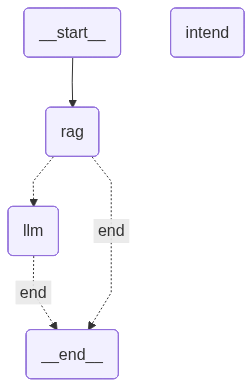

In [ ]:
# Configure graph
graph = StateGraph(State)

# Add nodes
graph.add_node("rag", rag_handler_with_explanation)
graph.add_node("llm", llm_handler)
graph.add_node("intend", intend_handler)

# Set entry point
graph.set_entry_point("rag")


##################
#### -------> for intent detection 
#graph.set_entry_point("intend")
###################



#### ore we can use the graph.node(START,end)

# Add conditional edges
def route_next(state):
    return state.get("next_node", "end")
graph.add_conditional_edges(
    "intend",
    route_next,
    {
        "rag": "rag",
        "end": END
    }
)
graph.add_conditional_edges(
    "rag",
    route_next,
    {
        "llm": "llm",
        "end": END
    }
)

graph.add_conditional_edges(
    "llm",
    route_next,
    {"end": END}
)

# Compile workflow
workflow = graph.compile()

workflow

## Test the Workflow

In [ ]:
def process_query(query: str):
    """Process a query through the workflow."""
    initial_state = {
        "query": query,
        "messages": [
            SystemMessage(content="I am an AI assistant that can search and summarize job information."),
            HumanMessage(content=query)
        ],
        "next_node": None,
        "search_results": None
    }
    
    return workflow.invoke(initial_state)


test_query = "how are you"
print("workflow with query:", test_query)
result = process_query(test_query)

print("\n Response:")
for msg in result["messages"]:
    if isinstance(msg, AIMessage):
        print(msg.content)

workflow with query: how are you

 Response:
Match found: 07_DMART_Picker-Packer.json (distance: -0.217)
'
- Job Title: Picker Packer

- Company: DMART

- Location: All India

- Required Experience Level: Entry level (High School graduate) or equivalent experience acceptable with additional support required

- Expected Work Start Date: As soon as possible. Immediate start preferred, subject to background checks and drug testing results pending on time. Candidates who pass must be ready for immediate deployment upon offer acceptance due to high demand in packing warehouse operations.


# How to add Inmemory

In [19]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
import os
import dotenv
from langchain_openai import AzureChatOpenAI

dotenv.load_dotenv()

llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),  
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    temperature=0.7,
)
response = llm.invoke("hello there")


print(response)



memory= MemorySaver()

# Define state schema
class GraphState(TypedDict):
    messages: Annotated[List,add_messages]

# Tool setup
tool = TavilySearch(max_results=2)
tools = [tool]

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

# Node definition
def tool_calling_llm(state: GraphState) -> GraphState:
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

# Graph creation
builder = StateGraph(GraphState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)

# # Invoke with proper message format
# ans=graph.invoke({"messages": "whats my name"})


content='Hello! How can I assist you today? 😊' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 9, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CaetoZ1ZUx1zFXiffUfL5T3gsao1e', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'prote

In [20]:
config={"configurable":{"thread_id":"1"}}
# Invoke with proper message format
ans=graph.invoke({"messages": "whats my name"},config=config)

In [21]:
ans["messages"][-1]

AIMessage(content="You haven't mentioned your name. Could you share it with me?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 1272, 'total_tokens': 1287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CaeuE5mfXGSRqiSN0SxRCivkCPAM9', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filt

In [22]:
ans=graph.invoke({"messages": "i am granth"},config=config)

In [23]:
ans=graph.invoke({"messages": "whats my name "},config=config)
ans["messages"][-1]

AIMessage(content='Your name is Granth! 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 1325, 'total_tokens': 1334, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-Caev8prqMTKPDRrN9MN4Jh7lYosIi', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, '

## Streaming 

In [24]:


memory= MemorySaver()

# Define state schema
class GraphState(TypedDict):
    messages: Annotated[List,add_messages]


# Node definition
def superbot(state: GraphState) -> GraphState:
    return {
        "messages": [llm_with_tools.invoke(state["messages"])]
    }

# Graph creation
builder = StateGraph(GraphState)
builder.add_node("superbot", superbot)
builder.add_edge(START, "superbot")

builder.add_edge("superbot", END)

graph = builder.compile(checkpointer=memory)

# # Invoke with proper message format
# ans=graph.invoke({"messages": "whats my name"})


In [32]:
config={"configurable":{"thread_id":"1"}}
# Invoke with proper message format
ans=graph.invoke({"messages": "did you mention suresh previously "},config=config)

In [33]:
ans["messages"][-1]

AIMessage(content='You\'re absolutely correct! I didn\'t mention **Suresh** earlier when listing general Indian names. My apologies for the inconsistency! \n\n"Suresh" is a more common name in general Indian contexts but not particularly associated with Jains from Karnataka. Thank you for pointing that out! 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 1623, 'total_tokens': 1683, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CaeyVip55JrZoYvPiX8dS5KLWdKcy', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm'

In [34]:
for chunk in graph.stream({"messages":"my name is gingallal"},config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content="That's a unique and wonderful name, Gingallal! Nice to meet you! 😊 Do you want to know anything specific about your name or its origin?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1695, 'total_tokens': 1728, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_b54fe76834', 'id': 'chatcmpl-CaezEEIZrRUcB56iNcBeJcOkdNhbn', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'sever

In [35]:
for chunk in graph.stream({"messages":"yess"},config=config,stream_mode="updates"):
    print(chunk)

{'superbot': {'messages': [AIMessage(content='Unfortunately, the name "Gingallal" is not something I recognize as a common name from any specific region or culture in India or elsewhere. However, it sounds quite unique and could have a personal, family, or regional significance. To understand more about your name, you might reflect on the following:\n\n1. **Cultural or Regional Origin**: Does the name have roots in your family, region, or community? Sometimes unique names emerge from dialects or local traditions.\n\n2. **Meaning**: Many Indian names have meanings derived from Sanskrit, Kannada, or other languages. Do you know if your name has any specific meaning, or could it be a creative or modern name?\n\n3. **Personal Significance**: Was your name chosen for a particular reason, such as honoring someone or conveying a special sentiment?\n\nIf you\'d like, I can try to help explore its possible etymology or any similar-sounding names! 😊', additional_kwargs={'refusal': None}, respons

# HITL

In [37]:
from typing import TypedDict, List, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from langchain_core.tools import tool
import pprint

memory = MemorySaver()

class GraphState(TypedDict):
    messages: Annotated[List, add_messages]

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    # Pause here; the return value will be provided via graph.resume(...)
    return interrupt({"query": query})

tavily = TavilySearch(max_results=2)
tools = [tavily, human_assistance]

llm_with_tools = llm.bind_tools(tools)

def tool_calling_llm(state: GraphState) -> GraphState:
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages":  [msg]}

builder = StateGraph(GraphState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tools", END)

graph = builder.compile(checkpointer=memory)

user_ip = "I need some expert guidance and assistance in building an AI agent. Could you please assist me?"
config = {"configurable": {"thread_id": "3"}}

stream = graph.stream(
    {"messages": user_ip},
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],
)

# for ev in stream:
#     if "__interrupt__" in ev:
#         # you’d collect real input here; using a stub string for demo
#         human_help = "Start by defining the agent's goal, tools, memory, and routing."
#         graph.resume(Command(resume=human_help), config=config, stream_mode="values")
#     else:
#         for m in ev["messages"]:
#             if isinstance(m, BaseMessage):
#                 m.pretty_print()
#             else:
#                 print(m)

for ev in stream:
    if "messages" in ev:
        # you’d collect real input here; using a stub string for demo
        human_help = "Start by defining the agent's goal, tools, memory, and routing."
        graph.invoke(Command(resume=human_help), config=config, stream_mode="values")
        pprint.pprint(ev["messages"])
    else:
        for m in ev["messages"]:
            if isinstance(m, BaseMessage):
                m.pretty_print()
            else:
                print(m)


[HumanMessage(content='I need some expert guidance and assistance in building an AI agent. Could you please assist me?', additional_kwargs={}, response_metadata={}, id='feb2303c-4a05-4001-b6e7-09727fafa8a2')]
[HumanMessage(content='I need some expert guidance and assistance in building an AI agent. Could you please assist me?', additional_kwargs={}, response_metadata={}, id='feb2303c-4a05-4001-b6e7-09727fafa8a2'),
 AIMessage(content="Of course! I'd be happy to help you build an AI agent. To get started, could you share more details about your project? Here are some questions to guide us:\n\n1. **Purpose of the AI Agent**:\n   - What is the primary function of your AI agent? (e.g., customer support, recommendation system, virtual assistant, data analysis, etc.)\n\n2. **Domain**:\n   - Is your AI agent tailored to a specific industry or domain? (e.g., healthcare, e-commerce, education)\n\n3. **Core Features**:\n   - What tasks do you want your AI agent to perform? (e.g., language underst